In [1]:
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import tripy
#plt.style.use('classic')

## extract building data and create convenient functions to create the 3D object

In [2]:
loc="./examples/Bronew.json"
file=open(loc,"r")
data=json.loads(file.read())


In [3]:
print(data['features'][0].keys())
print(data['features'][0]['type'])
print(data['features'][0]['id'])


dict_keys(['type', 'id', 'roadWidth', 'towerRadius', 'wallThickness', 'generator', 'version'])
Feature
values


In [4]:
typ=list()
ids=list()
for i in data["features"]:
    typ.append(i["type"])
    ids.append(i["id"])
print(typ)
print(ids)

['Feature', 'Polygon', 'GeometryCollection', 'GeometryCollection', 'GeometryCollection', 'GeometryCollection', 'MultiPolygon', 'MultiPolygon', 'MultiPolygon', 'MultiPolygon', 'MultiPolygon']
['values', 'earth', 'roads', 'walls', 'rivers', 'planks', 'buildings', 'prisms', 'squares', 'greens', 'fields']


In [5]:
earth=data["features"][1]["coordinates"]

In [7]:
plt.style.use('dark_background')


In [8]:
#buildings
buildings=data["features"][6]["coordinates"]

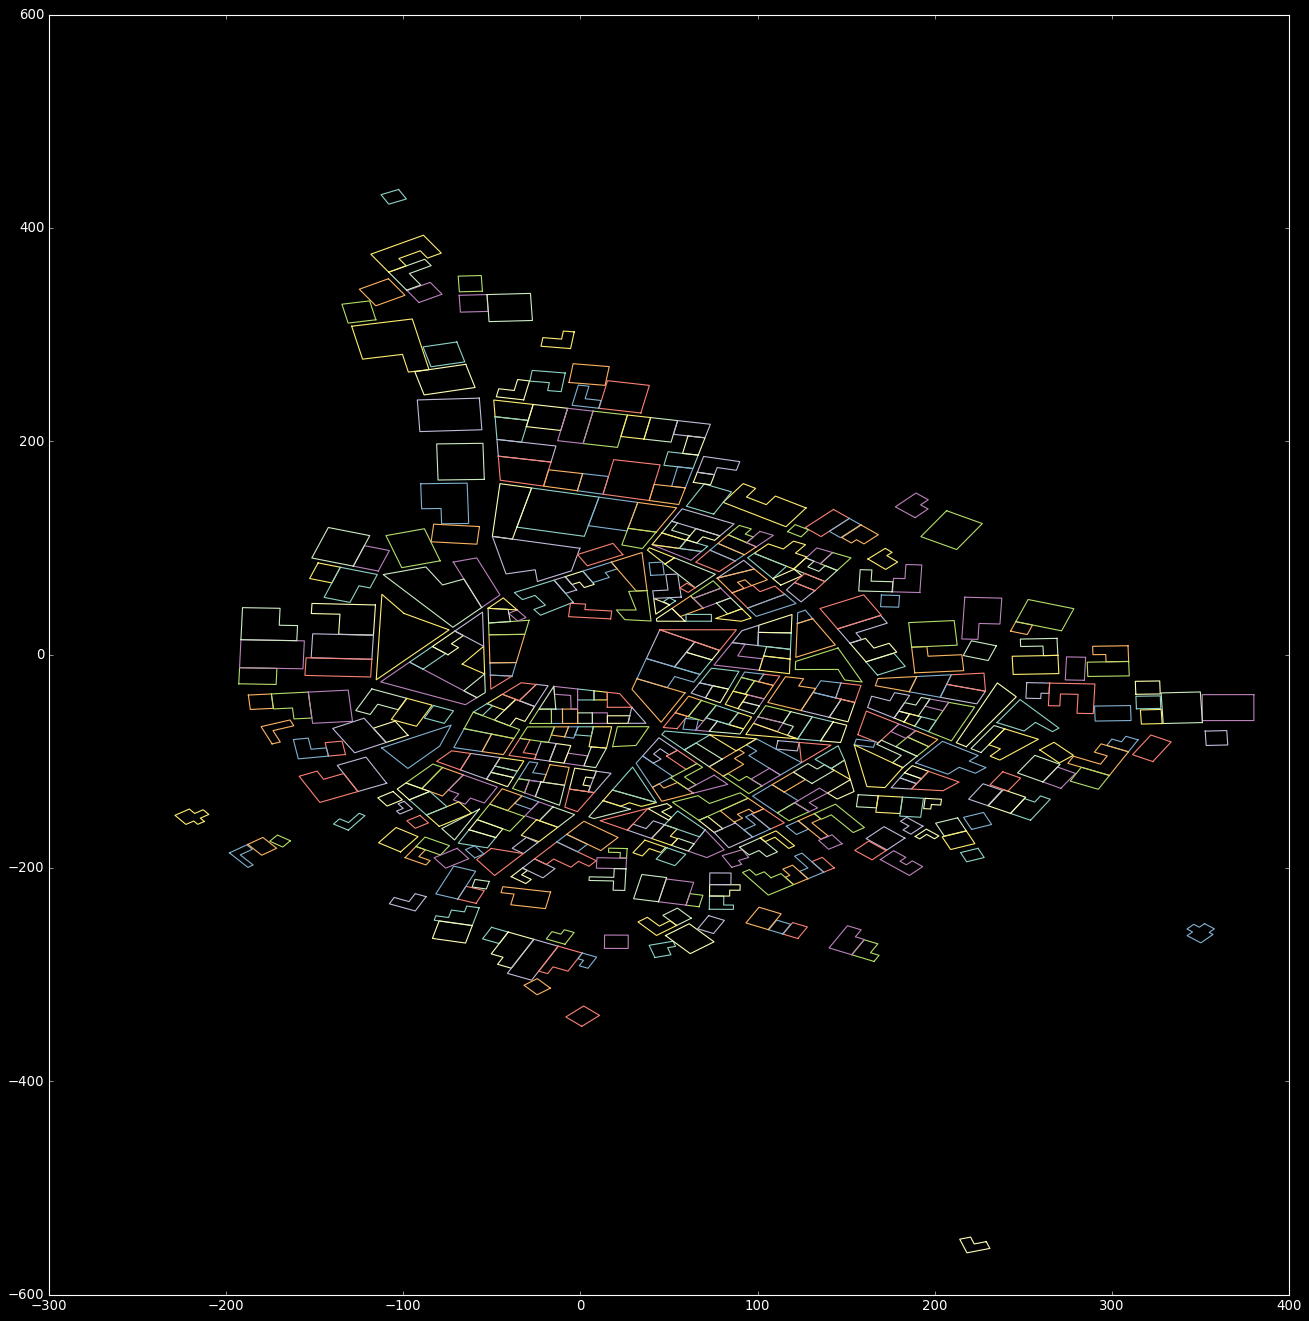

In [9]:
plt.figure(figsize=(20,20))
for i in range(len(buildings)):
    x,y=np.array(buildings[i]).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    plt.plot(x,y)
    

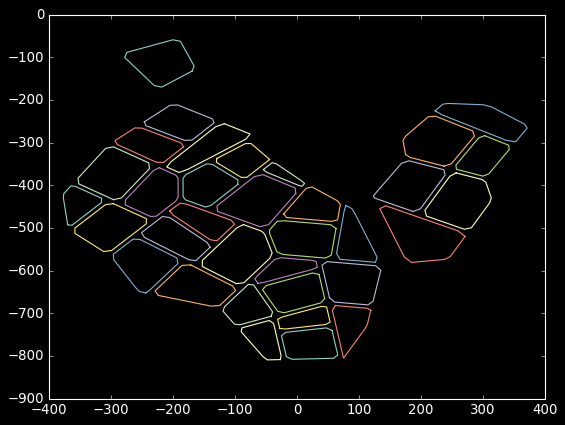

In [10]:
#fields
fields=data["features"][10]["coordinates"]
for i in range(len(fields)):
    x,y=np.array(fields[i][0]).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    plt.plot(x,y)

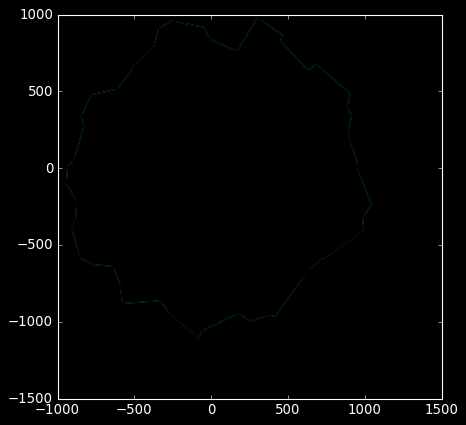

In [11]:
#test: trouver la normale correcte du contour des bâtiments
def normalFromSeg(p0,p1):
    '''
    p1, p2 : points of the segment
    Returns the normal (normalized) of the segment
    if the polygon is written in clockwise order, it's the correct one.
    '''
    dx=p1[0]-p0[0]
    dy=p1[1]-p0[1]
    norm=np.sqrt(dx*dx+dy*dy)
    dx=dx/norm
    dy=dy/norm
    #px=(x1+x0)/2.0
    #py=(y1+y0)/2.0

    #those are inside
    #nx=[px,px-dy]
    #ny=[py,py+dx]
    return [-dy,dx]

def getBuildingNormal(building):
    '''
    building: sequence of points representing the clockwise ordered contour of a building [[x1,x2,x3],[y1,y2,y3]] 
    '''
    x,y=np.array(building).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])

    fig,ax=plt.subplots()

    skip=True
    x0=0.0
    y0=0.0
    for x1,y1 in zip(x,y):
        if skip:
            x0=x1
            y0=y1
            skip=False
            continue

        #x0y0 - x1y1 is one segment
        dx=x1-x0
        dy=y1-y0
        norm=np.sqrt(dx*dx+dy*dy)
        dx=dx/norm
        dy=dy/norm
        px=(x1+x0)/2.0
        py=(y1+y0)/2.0

        #those are inside
        nx=[px,px-dy]
        ny=[py,py+dx]
        
        x0=x1
        y0=y1
        ax.plot(nx,ny,"red")


    ax.set_aspect('equal', 'box')
    ax.plot(x,y,"teal")
    for tri in tripy.earclip(building):
        ax.plot([tri[0][0],tri[1][0],tri[2][0]],[tri[0][1],tri[1][1],tri[2][1]],"black")
        
getBuildingNormal(earth[0])

In [12]:

def getSurface(contour,height):
    
    surfacetris=tripy.earclip(contour)
    #this above returns something of the form ( ((1,0),(0,1),(0,0)),((...),...),... )
    #this below converts it to array( [ [1,0,height], [0,1,height], [0,0,height] ],[[...],...]... )
    surface = [np.array([np.append(a,[height]),np.append(b,[height]),np.append(c,[height])]) 
               for a,b,c in surfacetris]
    return surface,np.array([[0,0,1]]*len(surface))
    
def getWalls(contour,height):
    triangles=list()
    normals=list() #each triangle has exactly one norm    
    x,y=np.array(contour).transpose()
    x=np.append(x,[x[0]])
    y=np.append(y,[y[0]])
    z=np.array([0]*len(x))#assume ground is 0
    
    x0,y0,z0=[0,0,0]
    skip=True
    for xi,yi,zi in zip(x,y,z):
        if skip:
            x0,y0,z0=[xi,yi,zi]
            skip=False
            continue
        
        tri1 = np.array([[x0,y0,z0],[xi,yi,height],[xi,yi,zi]])
        tri2 = np.array([[x0,y0,z0],[x0,y0,height],[xi,yi,height]])

        n = np.append(normalFromSeg([x0,y0],[xi,yi]),[height/2])
        triangles.append(tri1)
        triangles.append(tri2)
    
        normals.append(n)
        normals.append(n)
        x0,y0,z0=[xi,yi,zi]
    return triangles,normals

def make3DBuilding(building,height):
    '''
    building: sequence of points representing the clockwise ordered contour of a building [[x1,x2,x3],[y1,y2,y3]]
    (the building as we get it from data has one more [] around it so use [0])
    height: desired height of this building
    '''
    
    
    triangles,normals=getWalls(building,height)
    
    roof,nroof=getSurface(building,height)
    
    
    return {"walls":{"triangles": triangles,"normals":normals},"roof":{"triangles":roof,"normals":nroof}}
    
display(make3DBuilding(buildings[25][0],10))
display("-------------------------------")
display(getSurface(fields[5][0],0))

{'walls': {'triangles': [array([[ 58.995, -35.951,   0.   ],
          [ 45.509, -63.461,  10.   ],
          [ 45.509, -63.461,   0.   ]]),
   array([[ 58.995, -35.951,   0.   ],
          [ 58.995, -35.951,  10.   ],
          [ 45.509, -63.461,  10.   ]]),
   array([[ 45.509, -63.461,   0.   ],
          [ 29.058, -32.594,  10.   ],
          [ 29.058, -32.594,   0.   ]]),
   array([[ 45.509, -63.461,   0.   ],
          [ 45.509, -63.461,  10.   ],
          [ 29.058, -32.594,  10.   ]]),
   array([[ 29.058, -32.594,   0.   ],
          [ 31.858, -22.648,  10.   ],
          [ 31.858, -22.648,   0.   ]]),
   array([[ 29.058, -32.594,   0.   ],
          [ 29.058, -32.594,  10.   ],
          [ 31.858, -22.648,  10.   ]]),
   array([[ 31.858, -22.648,   0.   ],
          [ 58.995, -35.951,  10.   ],
          [ 58.995, -35.951,   0.   ]]),
   array([[ 31.858, -22.648,   0.   ],
          [ 31.858, -22.648,  10.   ],
          [ 58.995, -35.951,  10.   ]])],
  'normals': [array([ 0.8

'-------------------------------'

([array([[ 237.192, -355.321,    0.   ],
         [ 248.704, -349.792,    0.   ],
         [ 286.015, -285.122,    0.   ]]),
  array([[ 237.192, -355.321,    0.   ],
         [ 286.015, -285.122,    0.   ],
         [ 283.216, -272.733,    0.   ]]),
  array([[ 237.192, -355.321,    0.   ],
         [ 283.216, -272.733,    0.   ],
         [ 223.51 , -238.287,    0.   ]]),
  array([[ 237.192, -355.321,    0.   ],
         [ 223.51 , -238.287,    0.   ],
         [ 211.474, -239.676,    0.   ]]),
  array([[ 237.192, -355.321,    0.   ],
         [ 211.474, -239.676,    0.   ],
         [ 174.887, -285.241,    0.   ]]),
  array([[ 237.192, -355.321,    0.   ],
         [ 174.887, -285.241,    0.   ],
         [ 170.838, -295.076,    0.   ]]),
  array([[ 237.192, -355.321,    0.   ],
         [ 170.838, -295.076,    0.   ],
         [ 175.033, -328.188,    0.   ]]),
  array([[ 237.192, -355.321,    0.   ],
         [ 175.033, -328.188,    0.   ],
         [ 182.406, -334.882,    0.   ]])],

In [10]:
roof

NameError: name 'roof' is not defined

In [14]:
buildings[5][0].append(buildings[5][0][0])

[[17.407, 86.621],
 [34.73, 95.649],
 [37.555, 60.025],
 [31.518, 59.546],
 [17.407, 86.621]]

In [ ]:
height=10
roof,n=getRoof(buildings[5][0],10)
#center: avg(v1,v2,v3)
print(roof)
c=[ np.average(r,0) for r in roof]

print(c)

In [ ]:
roof[0]

In [ ]:
np.average(roof[0],0)

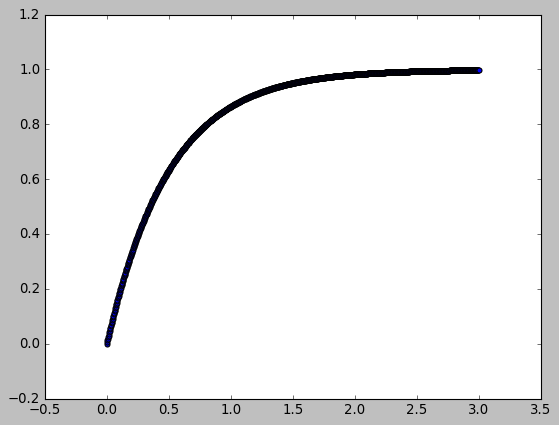

In [60]:
import random
n=10000
l=2
x=np.linspace(0,3,1000)
I=np.exp(-x*l)
plt.scatter(x,1-I)

In [63]:
r=random.random()

a,b=find_nearest(1-I,r)
print(r)
print(x[416])
print(sdist(r))
print(a,b)


0.4987728862209525
1.2492492492492493
0.3453479798499472
0.49877024524371916 115


In [79]:
def f(x,l):
    return np.exp(-x*1/l)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

def invcdf(r):
    return -np.log(1-r)*l

C:\tools\miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


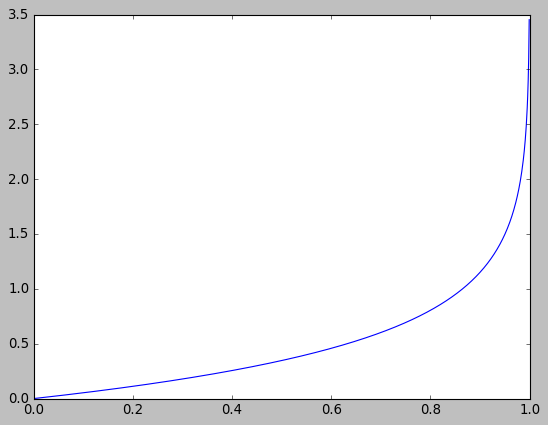

In [80]:
x2=np.linspace(0,1,1000)
Iinv=-np.log(1-x2)/l
plt.plot(x2,Iinv)



In [90]:
n=100000
l=50
integr=0
integr2=0
ds=0
ds2=0
for i in range(n):
    r=random.random()
    d2=r*10000
    d=sdist(r)
    integr=f(d,l)
    integr2=f(d2,l)
    ds+=d
    ds2+=d2
    
ds=ds/n    
ds2=ds2/n
integr=integr/n
integr2=integr2/n
print(integr,integr2,ds)

2.7932074421060493e-06 2.526941557078511e-68 50.03329431316658
